## Ejemplo2


# **Dyna-2**

## Presentación teórica del algoritmo

Dyna-2 es una arquitectura de aprendizaje por refuerzo, esta variación del algoritmo Dyna-Q combina el aprendizaje de diferencia temporal (`TD-Learning`) con la búsqueda de diferencia temporal (`TD-Search`). Mientras que el aprendizaje de diferencia temporal adquiere conocimiento general a partir de su experiencia pasada, la búsqueda de diferencia temporal adquiere conocimiento local especializándose en el estado actual del agente, mediante la simulación de experiencia futura.

La idea principal de Dyna-2 es combinar el `TD-Learning` con `TD-Search`, utilizando dos conjuntos de pesos: memorias a largo y corto plazo.

La memoria a largo plazo (`long-term memory`) actualiza sus pesos a partir de la experiencia real utilizando TD-learning, mientras que la memoria a corto plazo (`short-term memory`) actualiza sus pesos a partir de la experiencia simulada utilizando TD-search.

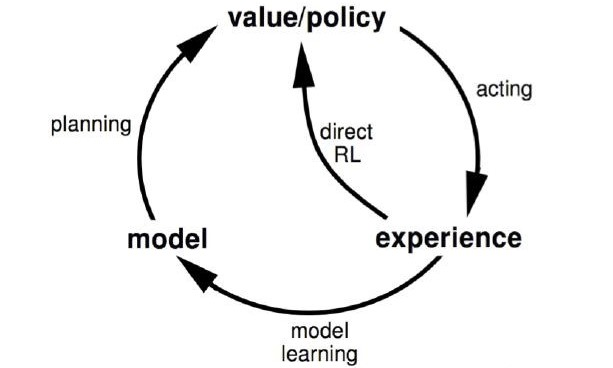

## Descripción de las secciones indicadas

**Integrated Architectures** (Sección 9.3)

Suena interesante y prometedor intentar unir las ventajas de los métodos basados en modelos y sin modelos, teniendo en cuenta sus ventajas y desventajes, mediante la integración de los procedimientos de aprendizaje y planificación.

Las arquitecturas que integran el aprendizaje y la planificación suelen ser  diferentes.
Por ejemplo, en el método sin modelo, el agente aprende las políticas directamente de la experiencia real con el entorno, mientras que en el método basado en modelos, el aprendizaje de modelos se aplica en primer lugar mediante las interacciones entre el agente y el entorno.

Al aplicar la planificación y la política sobre el modelo, se puede aprender de forma iterativa a partir de la experiencia de planificación.
Como el modelo se implementa entre el agente y el entorno, tenemos dos tipos de experiencia: en la experiencia real, la información se muestrea directamente de las interacciones entre el agente y el entorno, mientras que en la experiencia simulada es generada por la planificación del modelo.

Si la experiencia real como la experiencia simulada pueden unirse y considerarse de manera simultánea, podemos aprovechar las ventajas de los métodos sin modelos y basados en modelos, para mejorar la eficiencia y precisión del aprendizaje.

Por lo tanto, se propone la arquitectura Dyna, en el cuál durante el aprendizaje de políticas, el agente actualiza la política no solo a partir de la experiencia simulada con el modelo aprendido, sino considerando la experiencia real con el entorno real.

En el aprendizaje de políticas, la experiencia simulada puede garantizar la cantidad requerida de aprendizaje para reducir la varianza del aprendizaje de las características del entorno, por otro lado, la experiencia real muestra las características correctas y los cambios dinámicos del entorno, para reducir el sesgo a través de aprendiendo del entorno.

En el aprendizaje de Dyna-Q, se establece y mantiene una tabla Q para instruir las acciones del agente. Para cada episodio de aprendizaje, la tabla Q se aprende y actualiza a partir de la acción de un solo paso del agente en el entorno real. Además, el modelo simulado también aprende de la experiencia real y aplica la planificación para generar una experiencia simulada para el aprendizaje futuro.
De este modo debido al aumento del número de episodios, la tabla Q aprende y converge a los resultados correctos.

**TD Search** (Sección 9.4.3)

En comparación con los métodos de Monte Carlo, la búsqueda de TD no requiere desplegar una trayectoria para evaluar y actualizar la política actual. Sin embargo, durante la búsqueda de TD, para cada paso de la simulación, la política se actualiza y da instrucciones para seleccionar la acción para el siguiente estado.

La búsqueda de TD se aplica en el algoritmo Dyna-2, como se muestra en la figura de abajo, Algoritmo 4 Dyna-2.
En Dyna-2, el agente almacena dos conjuntos de pesos, denominados memoria a largo plazo y memoria a corto plazo. Aplicando el aprendizaje TD, los pesos de la memoria a corto plazo se actualizan con la experiencia simulada. La Q aprendida con los pesos de la memoria a corto plazo ayuda aún más al agente a realizar acciones en el entorno real.
El aprendizaje TD de nivel superior se aplica para actualizar los pesos de la memoria a largo plazo.
Finalmente, la Q aprendida con pesos θ es la política aprendida para el agente.

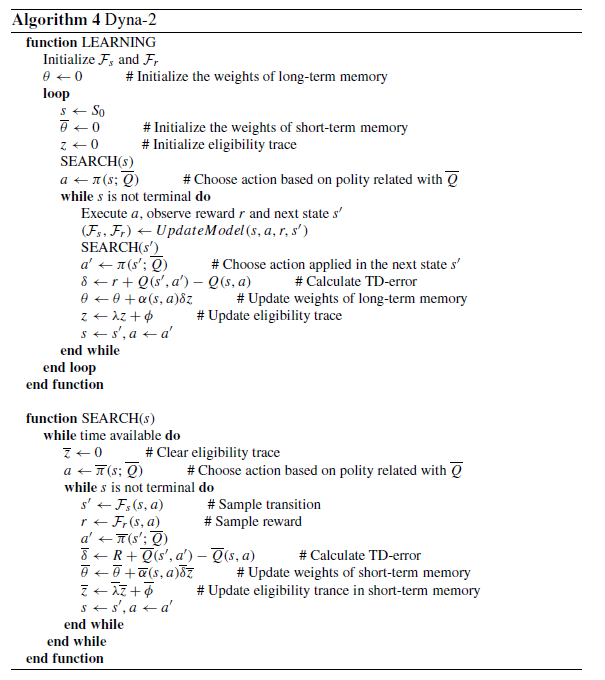

## Implementación de las fases que corresponden al algoritmo indicados en la presentación

In [ ]:
# Contiene la funcionalidad básica de un agente, como entrenar y comparar
class Agent:
    def allowlearn(self):
        self.learn = 1

    def preventlearn(self):
        self.learn = 0

    # Entrena al agente computando 'n_episodes' episodios.
    # Devuelve la recompensa promedio por episodio.
    def train(self, n_episodes):
        print('Entrenando...')
        self.allowlearn()
        return self.runEpisodes(n_episodes) / n_episodes

    # Compare el agente calculando los episodios 'n_episodes'.
    # Retorna la recompensa promedio por episodio.
    def benchmark(self, n_episodes):
        print('Evaluación...')
        self.preventlearn()
        return self.runEpisodes(n_episodes) / n_episodes

    # Calcula los 'n_episodes' episodios.
    # Devuelve la recompensa promedio por episodio.
    def runEpisodes(self, n_episodes):
        accumulatedReward = 0
        for episode_i in range(n_episodes):
            accum_reward, terminal_state = self.learning()
            accumulatedReward += accum_reward  # Actualizar la recompensa acumulada
            print('Episodio ', episode_i, ': Estado final', terminal_state)
        return accumulatedReward

In [ ]:
# Implementa una política de e-greedy para un agente utilizando la aproximación de la función de valor.
# La política devuelve una acción dado un estado de entrada y una función VFA.
class EGreedyPolicyVFA:
    def __init__(self, epsilon, decay = 1):
        self.epsilon = epsilon
        self.decay = decay

    def setNActions(self, nA):
        self.nA = nA

    def getAction(self, VFA, featurize, state):
        # VFA es el aproximador de función de valor
        if np.random.random() > self.epsilon:
            # Realiza una acción greedy
            return self.greedyAction(VFA, featurize, state)
        # Realiza una acción exploratoria
        else: return self.randomAction()

    # Retorna una acción aleatoria
    def randomAction(self):
        return np.random.randint(self.nA)

    # Retorna una acción greedy
    def greedyAction(self, VFA, featurize, state):
        maxima_index = [] # Acciones con valor máximo
        maxVal = None # Valor de las mejores acciones actuales

        for action in range(self.nA):
            # Obtiene el valor del par de acción de estado de VFA
            features = featurize.featureStateAction(state, action)
            value = VFA.getValue(features)

            if maxVal is None: # Para el primer (s,a), inicializa 'maxVal'
                maxVal = value
            if value > maxVal: # Si la acción es mejor que las anteriores, se actualiza
                maxima_index = [action]
                maxVal = value
            elif value == maxVal: # Si la acción es igual de buena, se agrega
                maxima_index.append(action)

        # Se elige al azar una de las mejores acciones.
        return np.random.choice(maxima_index)

    # Retorna una matriz que contiene la acción con el valor más alto para cada estado
    def getDetArray(self, VFA, featurize, nS):
        detActions = np.zeros((nS, 1))
        actionVals = np.zeros((self.nA, 1)) # Almacena los valores de todas las acciones en un estado dado

        for state in range(nS):
            for action in range(self.nA):
                features = featurize.featureStateAction(state, action)
                actionVals[action] = VFA.getValue(features)
            detActions[state] = np.argmax(actionVals) # Elija el valor más alto
        return detActions

    # El épsilon de la política decae según el parámetro 'decay'
    def epsilonDecay(self):
        self.epsilon *= self.decay

    # Actualiza el epsilon para disminuir la exploración cuando decay<1
    def episodeUpdate(self):
        self.epsilonDecay()

In [ ]:
# -featureState(estado) devuelve la función correspondiente al estado s como una tabla
# -featureStateAction(estado, acción) devuelve la función correspondiente al par estado-acción (s,a) como una tabla
class Featurize():
    def set_nSnA(self, nS, nA):
        self.nS = nS
        self.nA = nA

    def featureState(self, state):
      feature = np.zeros((self.nS, 1))
      feature[state] = 1
      return feature
      # return featureTableState(state, self.nS)

    def featureStateAction(self, state, action):
      feature = np.zeros((self.nS * self.nA, 1))
      feature[state * self.nA + action] = 1
      return feature
        # return featureTableStateAction(state, action, self.nS, self.nA)

In [ ]:
# Implementación de la aproximación de la función de valor lineal a través de la combinación lineal de características
class LinearVFA:
    # Inicializar el vector de pesos a un valor fijo
    def setUpWeights(self, dimensions, value = 1):
        self.weights = np.ones(dimensions) * value

    #def returnWeights(self, dimensions, value = 1):
    #    return np.ones(dimensions) * value

    def getValue(self, features):
        return np.dot(features.T, self.weights)

    def getGradient(self, features):
        return features

    def updateWeightsDelta(self, delta_weight):
        self.weights += delta_weight

    #def updateWeightsMatrix(self, A, b):
    #    self.weights = np.matmul(np.linalg.inv(A), b)

    def getWeights(self):
        return self.weights

    def setWeights(self, weights):
        self.weights = weights

In [ ]:
class Tabla_busqueda_Modelo:
    def __init__(self, nS, nA):
        self.nS = nS
        self.nA = nA
        self.N = np.zeros((nS, nA)) # Mantiene un registro de la cantidad de veces que ha aparecido (s,a)
        self.SprimeCounter = np.zeros((nS, nA, nS)) # Número de veces que (s,a) resultó en s'
        self.Rcounter = np.zeros((nS, nA)) # Recompensa total obtenida por (s,a)
        self.observedStates = [] # estados que han aparecido antes
        self.observedActions = [[] for i in range(nS)] # acciones observadas antes de cada estado
        self.terminalStates = []

    # La experiencia se considera como una tupla de (estado, acción, recompensa, estado_siguiente)
    def addExperience(self, experience):
        s, a, r, s_prime = experience
        self.N[s][a] += 1
        self.SprimeCounter[s][a][s_prime] += 1
        self.Rcounter[s][a] += r
        if not s in self.observedStates: self.observedStates.append(s)
        if not a in self.observedActions[s]: self.observedActions[s].append(a)

    # Muestras estado siguiente aleatorio que resultan de (s,a)
    def sampleStatePrime(self, state, action):

        if self.N[state][action] == 0: return np.random.choice(range(self.nS))

        prob = self.SprimeCounter[state][action] / self.N[state][action]
        return np.random.choice(range(self.nS), p = prob)

    # Muestra recompensa aleatoria de (s,a)
    def sampleReward(self, state, action):
        # If there is no information about (s,a), then return a fixed reward
        if self.N[state][action] == 0: return 0

        return self.Rcounter[state][action] / self.N[state][action]

    # Muestra un estado aleatorio que se ha observado antes
    def sampleRandState(self):
        return np.random.choice(self.observedStates)

    # Muestra una acción aleatoria observada previamente en un estado dado
    def sampleRandAction(self, state):
        return np.random.choice(self.observedActions[state])

    # Proporcionar conocimiento del modelo sobre los estados terminales.
    def addTerminalStates(self, term_states):
        self.terminalStates = term_states


    def isTerminal(self, state):
        return state in self.terminalStates


In [ ]:
import numpy as np

# Implementación del algoritmo Dyna2
class Dyna2(Agent):
    def __init__(self, env, policy, VFAshort, VFAlong, featurize, train_eps, planning, alpha, beta, gamma = 1, horizon = 100):
        #   -env: entorno de openAI gym
        #   -policy: Contiene una política desde la cual tomar muestras de acciones
        #   -VFAshort: Contiene el aproximador de función de valor para la memoria a corto plazo
        #   -VFAlong: Contiene el aproximador de función de valor para la memoria a largo plazo
        #   -featurize: object which featurizes states
        #   -train_eps: número de episodios aleatorios para generar experiencia para entrenar el modelo inicialmente
        #   -planning: number of planning steps
        #   -alpha: parámetro de tamaño de paso para la actualización de la función de valor de memoria a largo plazo
        #   -beta: parámetro de tamaño de paso para la actualización de la función de valor de memoria a corto plazo
        #   -lamda: parámetro de descuento de seguimiento
        #   -gamma: parámetro de tasa de descuento de recompensa
        #   -horizon: pasos finitos del horizonte

        self.env = env
        self.policy = policy
        self.VFAshort = VFAshort
        self.VFAlong = VFAlong
        self.featurize = featurize
        self.planning = planning
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.horizon = horizon
        # self.verbosity = verbosity

        self.nS = env.observation_space.n   # Número de estados
        self.nA = env.action_space.n    # Número de acciones
        self.policy.setNActions(self.nA)
        self.featurize.set_nSnA(self.nS, self.nA)
        self.featDim = featurize.featureStateAction(0,0).shape # Dimensiones del vector feature
        self.VFAshort.setUpWeights(self.featDim) # Inicializa los pesos para el VFA para la memoria a corto plazo
        self.VFAlong.setUpWeights(self.featDim) # Inicializa los pesos para el VFA para la memoria a largo plazo
        self.QVFA = LinearVFA() # Q(s,a) se aproxima a través de la aproximación de función de valor lineal,
        # con pesos iguales a la suma de los pesos de los VFA de memoria a corto y largo plazo.
        self.updateQ() # Inicializa QVFA

        # Evitar inicialmente que el agente aprenda
        self.learn = 0

        # Inicializar modelo
        self.model = Tabla_busqueda_Modelo(self.nS, self.nA)
        self.model_learn = 0


        self.trainModel(train_eps)

    def trainModel(self, train_eps):
        self.model_learn = 1  # Model aprenderá
        self.preventlearn()   # La función de valor no se aprenderá
        self.runEpisodes(train_eps)
        self.model_learn = 0

    def updateQ(self):
        weights_short = self.VFAshort.getWeights()
        weights_long = self.VFAlong.getWeights()
        Qweights = weights_long + weights_short # Suponiendo que ambos VFA usan la misma función de características
        self.QVFA.setWeights(Qweights)

    # Calcula un solo episodio.
    # Devuelve el retorno de la recompensa del episodio..
    def learning(self):
        episodeReward = 0

        # Limpiar la memoria a corto plazo
        self.VFAshort.setUpWeights(self.featDim) # Inicializar pesos para el VFA para memoria a corto plazo

        state = self.env.reset() # Initialize S
        if self.learn:
            self.search(state) # Buscar para actualizar la memoria a corto plazo
            self.updateQ()


        action = self.policy.getAction(self.QVFA, self.featurize, state)

        # Repetir para cada episodio
        for t in range(self.horizon):

            state, action, reward, done = self.step(state, action)

            # Actualizar el retorno del episodioo total
            episodeReward += reward

            # Terminar si el estado siguiente es un estado terminal
            if done: break


        if self.learn: self.policy.episodeUpdate()

        return episodeReward, state

    # TD-search(state)
    def search(self, state):
        for ep in range(self.planning):
            s = state
            self.updateQ()
            a = self.policy.getAction(self.QVFA, self.featurize, s)
            for k in range(self.horizon):
                s_prime = self.model.sampleStatePrime(s, a)
                r = self.model.sampleReward(s, a)
                self.updateQ()
                a_prime = self.policy.getAction(self.QVFA, self.featurize,
                    s_prime) #
                self.TDupdateShort(s, a, r, s_prime, a_prime)
                if self.model.isTerminal(s_prime): break
                s = s_prime
                a = a_prime
    # Pasos para recorrer el entorno
    def step(self, state, action):

        state_prime, reward, done, info = self.env.step(action)

        # Actualiza el modelo con la nueva experiencia
        if self.learn or self.model_learn:
            experience = (state, action, reward, state_prime)
            self.model.addExperience(experience)

        self.search(state_prime)
        action_prime = self.policy.getAction(self.QVFA, self.featurize,
            state_prime)

        # Actualiza memoria a largo plazo
        if self.learn:
            self.TDupdateLong(state, action, reward, state_prime, action_prime)

        return state_prime, action_prime, reward, done

    def getValueMemory(self, features):
        value_short = self.VFAshort.getValue(features)
        value_long = self.VFAlong.getValue(features) #
        total_value = value_short + value_long
        return total_value

    def TDupdateShort(self, state, action, reward, state_prime, action_prime):
        # Calcular los vectores de características pertinentes
        features = self.featurize.featureStateAction(state, action)
        features_prime = self.featurize.featureStateAction(state_prime, action_prime)


        value = self.getValueMemory(features)
        value_prime = self.getValueMemory(features_prime)


        # Calcula TD-error
        # r + Q(s', a') − Q(s, a)
        TD_error = (reward + self.gamma * value_prime - value)

        # Obtener peso delta
        delta_w = (self.beta * TD_error * self.VFAshort.getGradient(features))
        self.VFAshort.updateWeightsDelta(delta_w)

    def TDupdateLong(self, state, action, reward, state_prime, action_prime):

        features = self.featurize.featureStateAction(state, action)
        features_prime = self.featurize.featureStateAction(state_prime, action_prime)

        value = self.VFAlong.getValue(features)
        value_prime = self.VFAlong.getValue(features_prime)

         # Calcula TD-error
        # r + Q(s', a') − Q(s, a)
        TD_error = (reward + self.gamma * value_prime - value)

        # Obtener peso delta
        delta_w = (self.alpha * TD_error * self.VFAlong.getGradient(features))
        self.VFAlong.updateWeightsDelta(delta_w)

In [ ]:
import gym
import matplotlib.pyplot as plt

env = gym.make('CliffWalking-v0')

epsilon = 0.8
policyVFA = EGreedyPolicyVFA(epsilon, decay=0.9)

VFA = LinearVFA()
feature = Featurize()
init_train_model = 0 # Sin conocimiento previo del modelo
H = 30

training_episodes = 35
n_plot_points = 35
eps_benchmark = 10

alpha = 0.4
beta = 0.4
plan = 20
agente = Dyna2(env, policyVFA, LinearVFA(), VFA, feature, init_train_model, plan, alpha, beta, horizon = H)
# Proporcionar conocimiento del modelo sobre los estados terminales.
agente.model.addTerminalStates([47])

agents = [agente]

eps_per_point = int(training_episodes / n_plot_points)
benchmark_data = np.zeros((1, n_plot_points))

# agentes sin formación
benchmark_data[0][0] = agente.benchmark(eps_benchmark)
# Capacitar y comparar agentes

for point_i in range(1, n_plot_points):
    # for agent_i in range(1):
  print('Iteración', (point_i+1)*eps_per_point)
  print(agente.train(eps_per_point))
  benchmark_data[0][point_i] = agente.benchmark(eps_benchmark)


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Evaluación...
Episodio  0 : Estado final 25
Episodio  1 : Estado final 25
Episodio  2 : Estado final 36
Episodio  3 : Estado final 36
Episodio  4 : Estado final 5
Episodio  5 : Estado final 36
Episodio  6 : Estado final 12
Episodio  7 : Estado final 12
Episodio  8 : Estado final 36
Episodio  9 : Estado final 2
Iteración 2
Entrenando...
Episodio  0 : Estado final 36
-525.0
Evaluación...
Episodio  0 : Estado final 1
Episodio  1 : Estado final 3
Episodio  2 : Estado final 1
Episodio  3 : Estado final 18
Episodio  4 : Estado final 0
Episodio  5 : Estado final 1
Episodio  6 : Estado final 15
Episodio  7 : Estado final 24
Episodio  8 : Estado final 25
Episodio  9 : Estado final 24
Iteración 3
Entrenando...
Episodio  0 : Estado final 16
-129.0
Evaluación...
Episodio  0 : Estado final 24
Episodio  1 : Estado final 24
Episodio  2 : Estado final 1
Episodio  3 : Estado final 12
Episodio  4 : Estado final 3
Episodio  5 : Estado final 25
Episodio  6 : Estado final 0
Episodio  7 : Estado final 0
Epi

## Validación de resultados y ejemplos

Gráfica de recompensa promedio por iteración

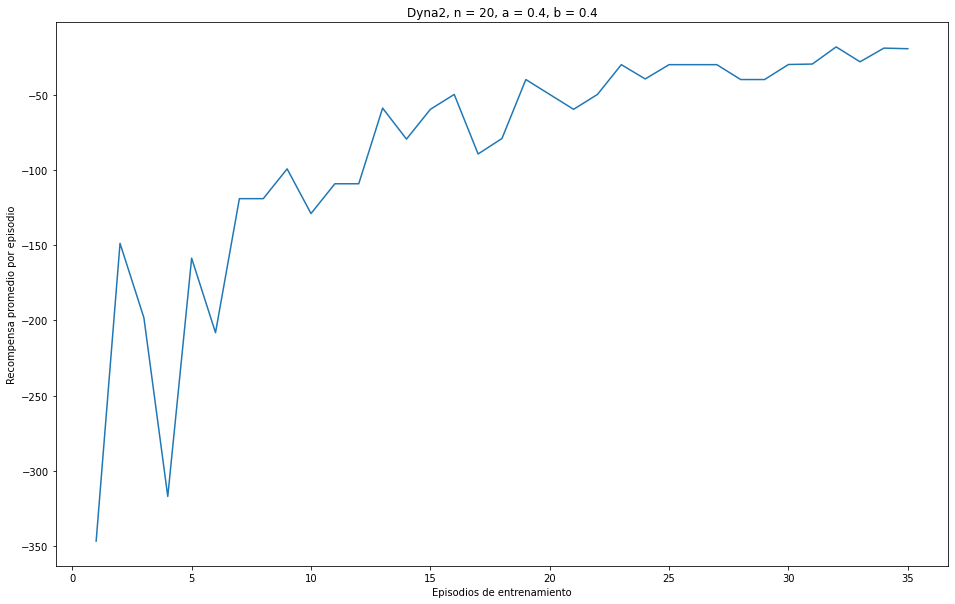

In [ ]:
# mostramos los resultados obtenidos por iteración
plt.figure(figsize=(16, 10))
xaxis = [eps_per_point*(i+1) for i in range(n_plot_points)]

title = 'Dyna2, n = ' + str(plan) + ', a = ' + str(alpha) + ', b = ' + str(beta)

plt.plot(xaxis, benchmark_data[0])
plt.xlabel('Episodios de entrenamiento')
plt.ylabel('Recompensa promedio por episodio')
plt.title(title)
plt.show()

Se obtiene como resultado la politica optima donde cada número representa la mejor acción para el estado correspondiente.

In [ ]:
# obtenemos la politica optima con la funcion fetDetArray()
p = agente.policy.getDetArray(VFA, agente.featurize, 48)
# redimensionamos el array para ver los estados de forma ordenada
p.reshape((4,12))

array([[3., 3., 2., 3., 0., 3., 2., 2., 2., 0., 0., 1.],
       [2., 2., 2., 2., 3., 2., 3., 2., 2., 2., 3., 0.],
       [1., 1., 1., 3., 3., 3., 3., 3., 3., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Simulación

In [ ]:
!pip install gym[toy_text]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.7 MB/s eta 0:00:00


In [ ]:
!apt install xvfb -y
!pip install pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 785 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.13 [785 kB]
Fetched 785 kB in 0s (2,937 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.13_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.13) ...
Setting up xvfb (2:1.19.6-1ubuntu4.13) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheel

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


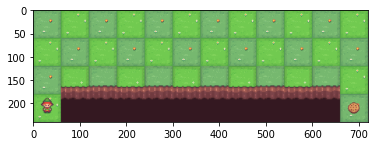

Acción: 0  ->  Estado: 24


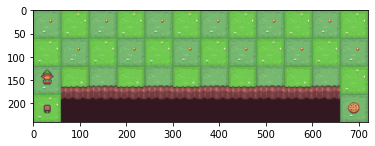

Acción: 1  ->  Estado: 25


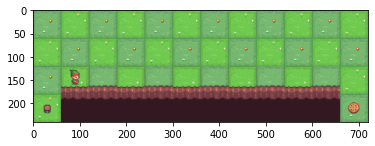

Acción: 1  ->  Estado: 26


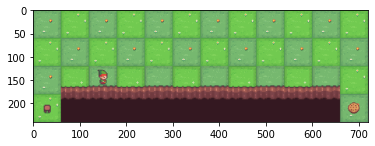

Acción: 1  ->  Estado: 27


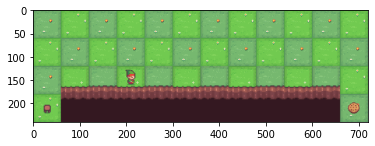

Acción: 3  ->  Estado: 26


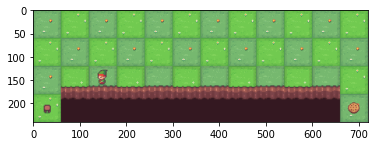

Acción: 1  ->  Estado: 27


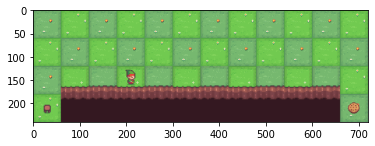

Acción: 3  ->  Estado: 26


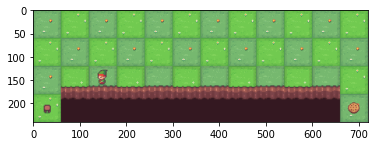

Acción: 1  ->  Estado: 27


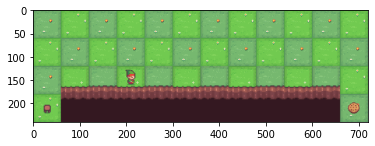

Acción: 3  ->  Estado: 26


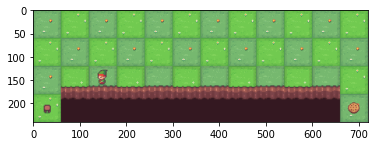

Acción: 1  ->  Estado: 27


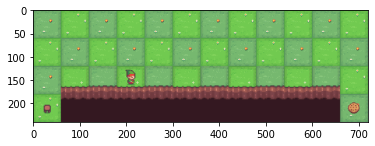

Acción: 3  ->  Estado: 26


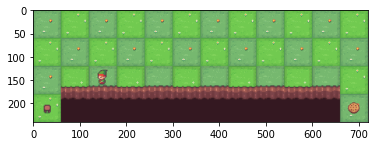

Acción: 1  ->  Estado: 27


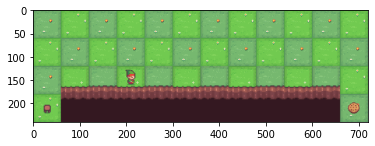

Acción: 3  ->  Estado: 26


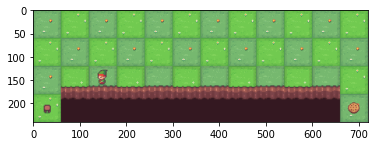

Acción: 1  ->  Estado: 27


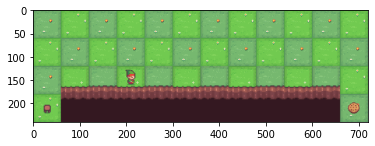

Acción: 3  ->  Estado: 26


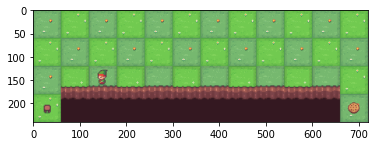

Acción: 1  ->  Estado: 27


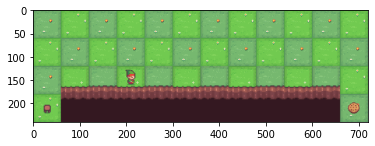

Acción: 3  ->  Estado: 26


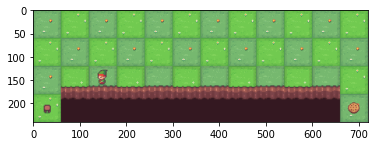

Acción: 1  ->  Estado: 27


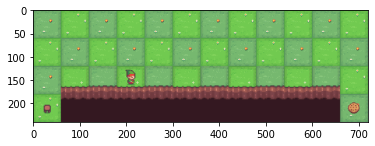

Acción: 3  ->  Estado: 26


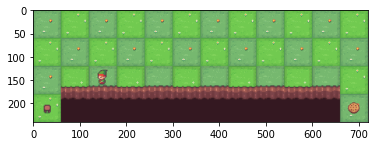

Acción: 1  ->  Estado: 27


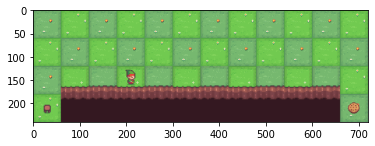

Acción: 3  ->  Estado: 26


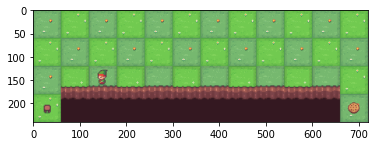

Acción: 1  ->  Estado: 27


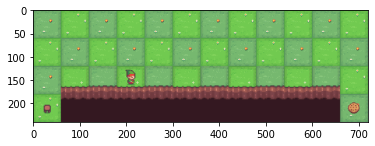

Acción: 3  ->  Estado: 26


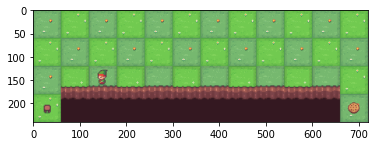

Acción: 1  ->  Estado: 27


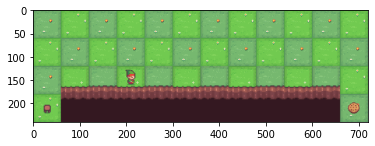

Acción: 3  ->  Estado: 26


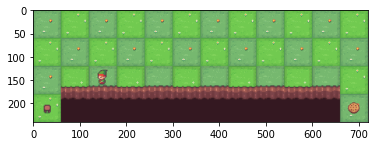

Acción: 1  ->  Estado: 27


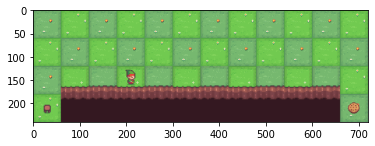

Acción: 3  ->  Estado: 26


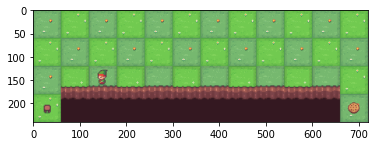

Acción: 1  ->  Estado: 27


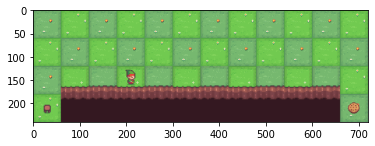

Acción: 3  ->  Estado: 26


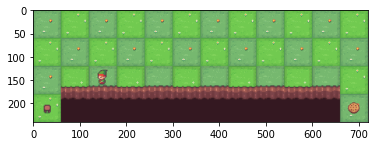

Acción: 1  ->  Estado: 27


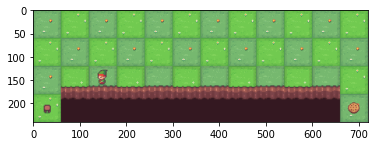

In [ ]:
import matplotlib.pyplot as plt
import gym
from pyvirtualdisplay import Display
Display().start()
from IPython import display

env = gym.make('CliffWalking-v0')
env.reset()
# mostramos una simulación iniciando en el estado 36
state = 36
for _ in range(30):
    plt.imshow(env.render('rgb_array'))
    display.display(plt.gcf())
    # usamos getAction para obtener la accion a realizar
    action = agente.policy.getAction(VFA, agente.featurize, state)
    # obtenemos el siguiente estado usando la accion anterior
    state, done, a, prob = env.step(action)
    print('Acción:', action, ' ->  Estado:', state)

En la simulación observamos que la persona no llega al estado deseado (47) sin embargo en el entrenamiento se puede ver que en las ultimas iteraciones el modelo logra llegar. Esto puede deberse a que para calculo de la mejor acción